In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from scipy.stats import norm

In [117]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from pprint import pprint

# Loading Data

Credit: Ahmad Hussein, Mohammed Ali

In [3]:
# reading data from csv files
train_imputed= pd.read_csv("train_imputed.csv")
train_undersampled_imputed= pd.read_csv("train_undersampled_imputed.csv")
train_oversampled_imputed= pd.read_csv("train_oversampled_imputed.csv")

test_imputed= pd.read_csv("test_imputed.csv")

In [4]:
# data processing -- NOTE: we now call train_oversampled_imputed just train_imputed for succinctness
y_train_imputed = train_oversampled_imputed.iloc[:,64]
x_train_imputed = train_oversampled_imputed.drop('class', inplace=True, axis=1)
x_train_imputed = train_oversampled_imputed.copy()

y_test_imputed = test_imputed.iloc[:,64]
x_test_imputed = test_imputed.drop('class', inplace=True, axis=1)
x_test_imputed = test_imputed.copy()

In [5]:
# winsorizing
for i in range(0,64):
        winsorize(x_train_imputed.iloc[:,0], limits=[0.1, 0.1])
        winsorize(x_test_imputed.iloc[:,0], limits=[0.1, 0.1])
        
x_train_imputed.describe();
x_test_imputed.describe();

# Helper Functions and Reference Variables

Attribute dictionary for reference

In [6]:
attributes = {1: "net profit / total assets",
              2: "total liabilities / total assets",
              3: "working capital / total assets",
              4: "current assets / short-term liabilities",
              5: "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
              6: "retained earnings / total assets",
              7: "EBIT / total assets",
              8: "book value of equity / total liabilities",
              9: "sales / total assets",
             10: "equity / total assets",
             11: "(gross profit + extraordinary items + financial expenses) / total assets",
             12: "gross profit / short-term liabilities",
             13: "(gross profit + depreciation) / sales",
             14: "(gross profit + interest) / total assets",
             15: "(total liabilities * 365) / (gross profit + depreciation)",
             16: "(gross profit + depreciation) / total liabilities",
             17: "total assets / total liabilities",
             18: "gross profit / total assets",
             19: "gross profit / sales",
             20: "(inventory * 365) / sales",
             21: "sales (n) / sales (n-1)",
             22: "profit on operating activities / total assets",
             23: "net profit / sales",
             24: "gross profit (in 3 years) / total assets",
             25: "(equity - share capital) / total assets",
             26: "(net profit + depreciation) / total liabilities",
             27: "profit on operating activities / financial expenses",
             28: "working capital / fixed assets",
             29: "logarithm of total assets",
             30: "(total liabilities - cash) / sales",
             31: "(gross profit + interest) / sales",
             32: "(current liabilities * 365) / cost of products sold",
             33: "operating expenses / short-term liabilities",
             34: "operating expenses / total liabilities",
             35: "profit on sales / total assets",
             36: "total sales / total assets",
             37: "(current assets - inventories) / long-term liabilities",
             38: "constant capital / total assets",
             39: "profit on sales / sales",
             40: "(current assets - inventory - receivables) / short-term liabilities",
             41: "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
             42: "profit on operating activities / sales",
             43: "rotation receivables + inventory turnover in days",
             44: "(receivables * 365) / sales",
             45: "net profit / inventory",
             46: "(current assets - inventory) / short-term liabilities",
             47: "(inventory * 365) / cost of products sold",
             48: "EBITDA (profit on operating activities - depreciation) / total assets",
             49: "EBITDA (profit on operating activities - depreciation) / sales",
             50: "current assets / total liabilities",
             51: "short-term liabilities / total assets",
             52: "(short-term liabilities * 365) / cost of products sold)",
             53: "equity / fixed assets",
             54: "constant capital / fixed assets",
             55: "working capital",
             56: "(sales - cost of products sold) / sales",
             57: "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
             58: "total costs /total sales",
             59: "long-term liabilities / equity",
             60: "sales / inventory",
             61: "sales / receivables",
             62: "(short-term liabilities *365) / sales",
             63: "sales / short-term liabilities",
             64: "sales / fixed assets"}

Code for a plotting function to help select classification threshold

In [112]:
def visualize_thresholds(name, model, x_train, y_train, x_test, y_test, try_threshold):
    precisions = []
    recalls = []
    accuracies = []
    thresholds = np.linspace(0,1,100)
    # for each potential threshold:
    for threshold in thresholds:
        # make predictions based on that threshold
        y_pred_proba = model.predict_proba(x_test)[:,1]
        preds = (y_pred_proba >= threshold).astype(int)
        # calculate precision and store that
        precision = precision_score(y_test, preds)
        precisions.append(precision)
        # calculate recall and store that
        recall = recall_score(y_test, preds)
        recalls.append(recall)
        # calculate accuracy and store that
        accuracy = accuracy_score(y_test, preds)
        accuracies.append(accuracy)
        
    # plot it all!
    plt.figure(figsize=[10,6])
    plt.plot(precisions,label="precision")
    plt.plot(recalls,label="recall")
    plt.plot(accuracies,label="accuracy")
    plt.axvline(x = try_threshold*100, color = 'b', label = 'threshold ='+str(try_threshold))
    plt.title("Model Metrics for Different Threshold Values, " + name)
    plt.legend()

# Baseline: Always Predict 0

In [106]:
# baseline predictions
baseline_preds = np.zeros(len(y_test_imputed))

## Results

Accuracy

In [107]:
accuracy_score(baseline_preds, y_test_imputed)

0.9527798933739527

Confusion Matrix

In [108]:
cm = metrics.confusion_matrix(y_test_imputed, baseline_preds)
print(cm)

[[2502    0]
 [ 124    0]]


Precision, Recall, F Score

In [109]:
baseline_results = precision_recall_fscore_support(y_test_imputed, baseline_preds, average='macro')
baseline_precision, baseline_recall, baseline_fscore, baseline_support = baseline_results
print("Precision: " + str(baseline_precision))
print("Recall: " + str(baseline_recall))
print("F Score: " + str(baseline_fscore))

Precision: 0.4763899466869764
Recall: 0.5
F Score: 0.4879095163806553


/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC

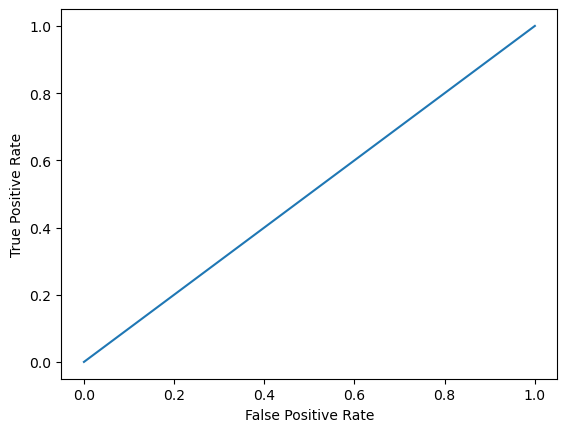

AUC:


0.5

In [110]:
y_pred_proba = baseline_preds
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, baseline_preds)

PRAUC

In [111]:
baseline_probas = baseline_preds
average_precision_score(y_test_imputed, baseline_probas, pos_label=1)

0.04722010662604722

# Logistic Regression

## Initial Model

### Fit

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
lr_model = LogisticRegression()

In [9]:
lr_model.fit(x_train_imputed, y_train_imputed)

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# predictions
lr_model_preds = lr_model.predict(x_test_imputed)

### Results

Accuracy

In [11]:
lr_model.score(x_test_imputed, y_test_imputed)

0.7056359482102056

Confusion Matrix

In [12]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model_preds)
print(cm)

[[1803  699]
 [  74   50]]


Precision, Recall, F Score

In [15]:
lr_model_results = precision_recall_fscore_support(y_test_imputed, lr_model_preds, average='macro')
lr_model_precision, lr_model_recall, lr_model_fscore, lr_model_support = lr_model_results
print("Precision: " + str(lr_model_precision))
print("Recall: " + str(lr_model_recall))
print("F Score: " + str(lr_model_fscore))

Precision: 0.5136655302434857
Recall: 0.5619246538253269
F Score: 0.4690116083034016


AUC

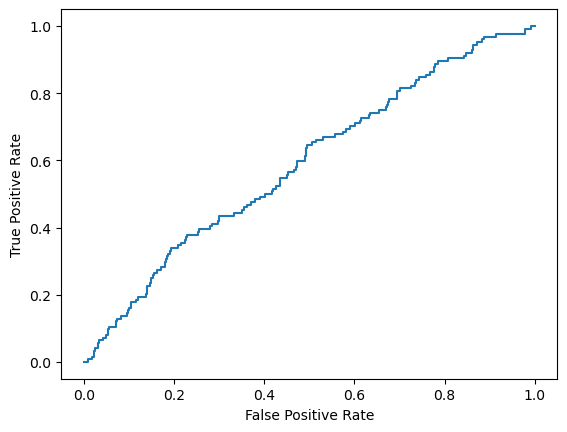

AUC:


0.5888869549521674

In [16]:
y_pred_proba = lr_model.predict_proba(x_test_imputed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, lr_model.predict_proba(x_test_imputed)[:,1])

PRAUC

In [17]:
lr_model_probas = lr_model.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, lr_model_probas[:,1],pos_label=1)

0.06312129714731511

### Interpretation

Coefficient magnitude:

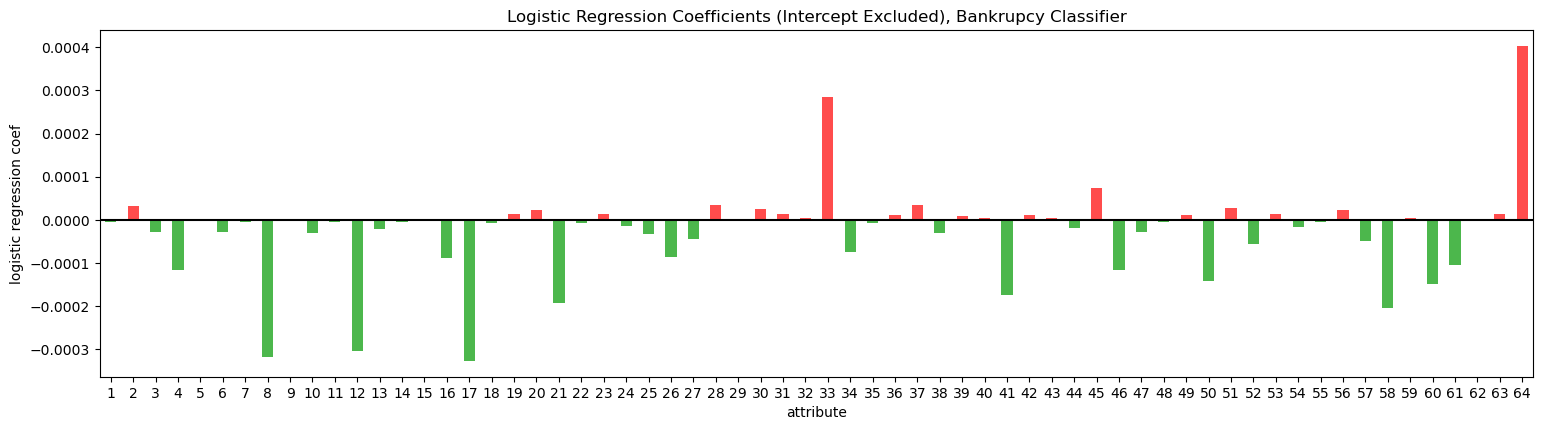

In [18]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = lr_model.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Logistic Regression Coefficients (Intercept Excluded), Bankrupcy Classifier");

In [19]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[8])
print(attributes[12])
print(attributes[17])

attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
book value of equity / total liabilities
gross profit / short-term liabilities
total assets / total liabilities


In [20]:
print("attribues that increase predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[33])
print(attributes[64])

attribues that increase predicted probability of bankrupcy (in desc order of coef size):
====
operating expenses / short-term liabilities
sales / fixed assets


Coefficient significance:

In [21]:
# significanc helper function, from user David Dale, stack overflow
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [22]:
# finding coefficient significance
lr_model_sigs = logit_pvalue(lr_model, x_train_imputed)

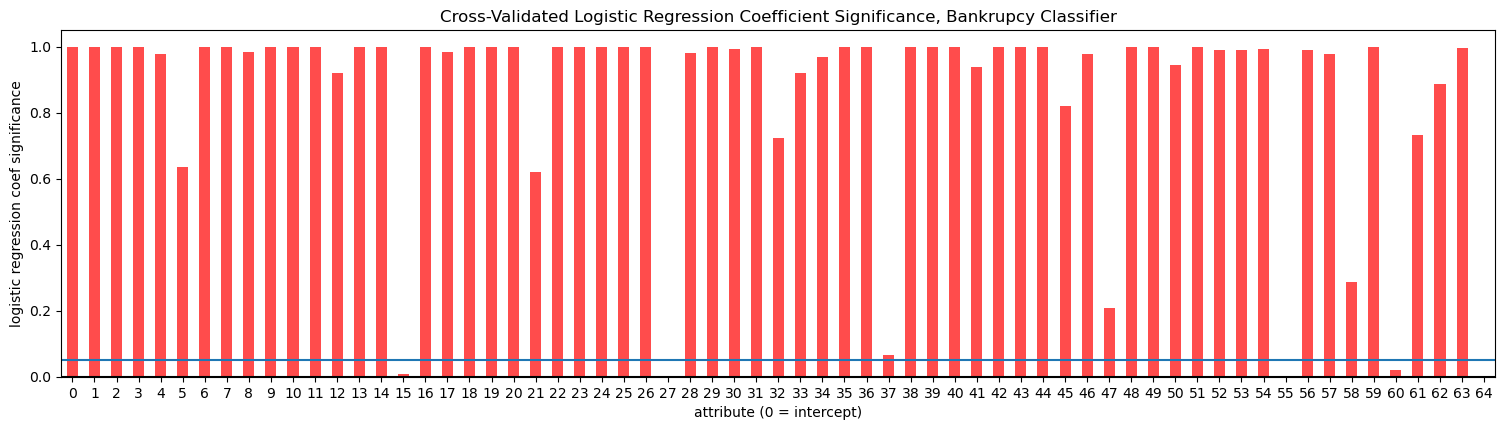

In [23]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(0,65),columns=["attr"])
to_plot["significance"] = lr_model_sigs

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['significance'] > 0
to_plot['significance'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(0,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute (0 = intercept)");
ax.set_ylabel("logistic regression coef significance");
ax.set_title("Cross-Validated Logistic Regression Coefficient Significance, Bankrupcy Classifier");
ax.axhline(0.05);

In [24]:
print("attibutes with significant (p<=0.05) regression coefficients:")
print("====")
print(attributes[15])
print(attributes[27])
print(attributes[55])
print(attributes[60])
print(attributes[64])

attibutes with significant (p<=0.05) regression coefficients:
====
(total liabilities * 365) / (gross profit + depreciation)
profit on operating activities / financial expenses
working capital
sales / inventory
sales / fixed assets


## Sparse Model

Retraining using only significant coefficients

### Fit

In [27]:
lr_model2 = LogisticRegression()

In [28]:
# x imputed with only significant regression coefficients included
x_train_signif = x_train_imputed[["Attr15","Attr27","Attr55","Attr60","Attr64"]]
x_test_signif = x_test_imputed[["Attr15","Attr27","Attr55","Attr60","Attr64"]]

In [29]:
 lr_model2.fit(x_train_signif, y_train_imputed)

LogisticRegression()

In [30]:
# predictions
lr_model2_preds = lr_model2.predict(x_test_signif)

### Results

Accuracy

In [31]:
lr_model2.score(x_test_signif, y_test_imputed)

0.682025894897182

Confusion Matrix

In [32]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model2_preds)
print(cm)

[[1741  761]
 [  74   50]]


Precision, Recall, F Score

In [33]:
lr_model2_results = precision_recall_fscore_support(y_test_imputed, lr_model2_preds, average='macro')
lr_model2_precision, lr_model2_recall, lr_model2_fscore, lr_model2_support = lr_model2_results
print("Precision: " + str(lr_model2_precision))
print("Recall: " + str(lr_model2_recall))
print("F Score: " + str(lr_model2_fscore))

Precision: 0.5104404656360715
Recall: 0.5495345658956705
F Score: 0.4567652571168084


AUC

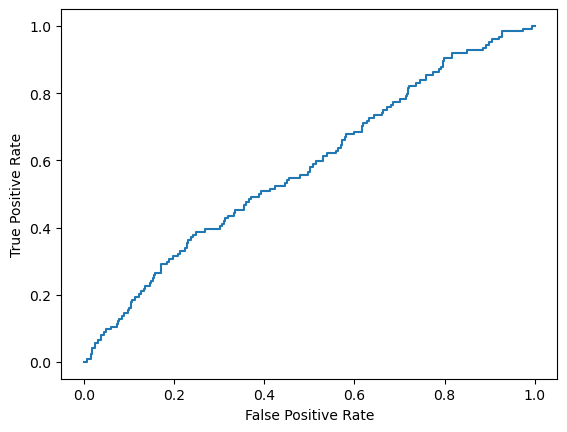

AUC:


0.5785919651375675

In [34]:
y_pred_proba = lr_model2.predict_proba(x_test_signif)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, lr_model2.predict_proba(x_test_signif)[:,1])

PRAUC

In [35]:
lr_model2_probas = lr_model2.predict_proba(x_test_signif)
average_precision_score(y_test_imputed, lr_model2_probas[:,1],pos_label=1)

0.06323150573388689

### Interpretation

Coefficient magnitude:

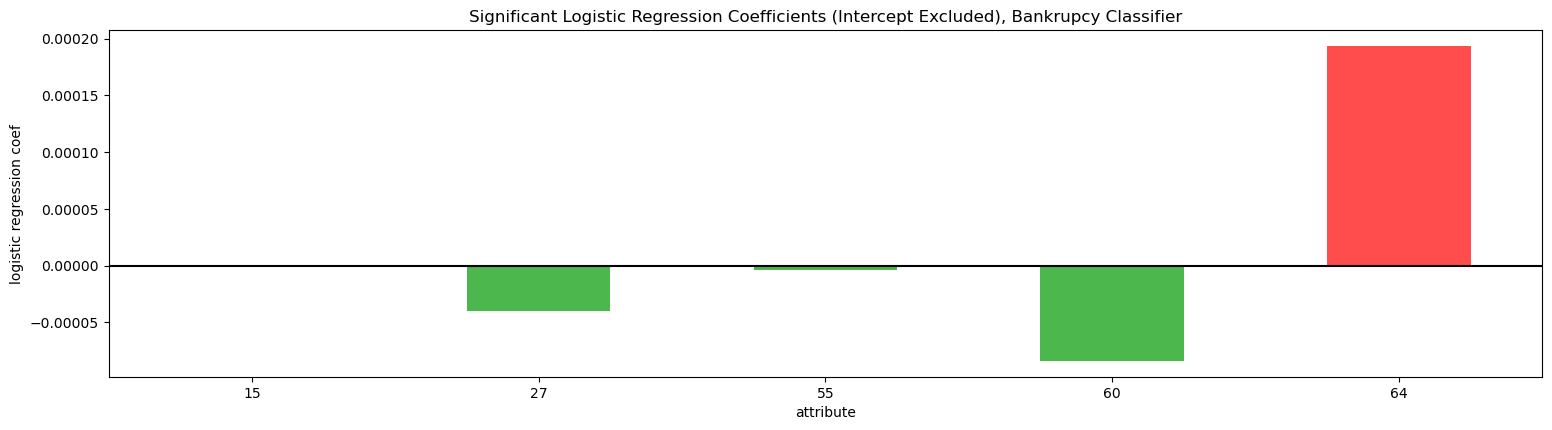

In [102]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame([15,27,55,60,64],columns=["attr"])
to_plot["coef"] = lr_model2.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels([15,27,55,60,64], rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Significant Logistic Regression Coefficients (Intercept Excluded), Bankrupcy Classifier");

In [37]:
print("significant attribues that increase predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[64])

significant attribues that increase predicted probability of bankrupcy (in desc order of coef size):
====
sales / fixed assets


## Cross-Validated Model

### Fit

Improving model performance using Regularization

In [38]:
# creating random grid
penalty = ['none','l2','l1','elaticnet']
lam = [x for x in np.linspace(start = 0, stop = 1, num = 100)]

# random grid
random_grid = {'penalty': penalty,'C':lam}

In [39]:
# random grid search
lr_model3 = LogisticRegression();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_model3_rcv = RandomizedSearchCV(estimator = lr_model3, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
lr_model3_rcv.fit(x_train_imputed, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/lin

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as 

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as 

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as 

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# cross-validated hyperparams
pprint(lr_model3_rcv.best_params_)

{'C': 0.9393939393939394, 'penalty': 'l2'}


In [41]:
# predictions
lr_model3_preds = lr_model3_rcv.predict(x_test_imputed)

### Results

In [42]:
# using cross-validation coefficients
lr_model3 = LogisticRegression(penalty='l2',C=0.010101010101010102)
lr_model3.fit(x_train_imputed, y_train_imputed)

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.010101010101010102)

New Accuracy:

In [43]:
lr_model3.score(x_test_imputed, y_test_imputed)

0.7795125666412795

Confusion Matrix:

In [44]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model3_preds)
print(cm)

[[2037  465]
 [  86   38]]


Precision, Recall, F Score

In [45]:
lr_model3_results = precision_recall_fscore_support(y_test_imputed, lr_model3_preds, average='macro')
lr_model3_precision, lr_model3_recall, lr_model3_fscore, lr_model3_support = lr_model3_results
print("Precision: " + str(lr_model3_precision))
print("Recall: " + str(lr_model3_recall))
print("F Score: " + str(lr_model3_fscore))

Precision: 0.5175190027990325
Recall: 0.5603001469791908
F Score: 0.501038493038493


AUC

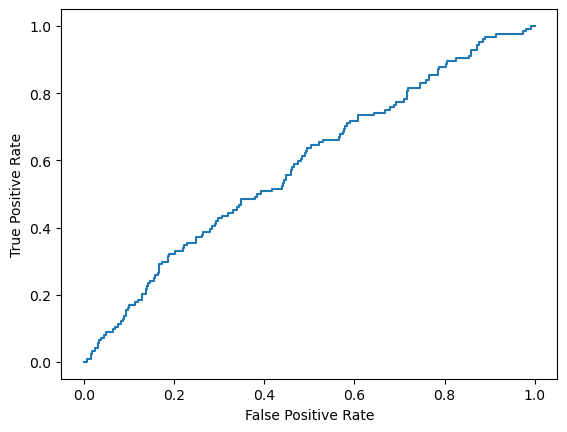

AUC:


0.585106108661458

In [48]:
y_pred_proba = lr_model3.predict_proba(x_test_imputed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, lr_model3.predict_proba(x_test_imputed)[:,1])

PRAUC:

In [49]:
lr_model3_probas = lr_model3.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, lr_model3_probas[:,1],pos_label=1)

0.06279820367791766

### Interpretation

Coefficient Magnitude:

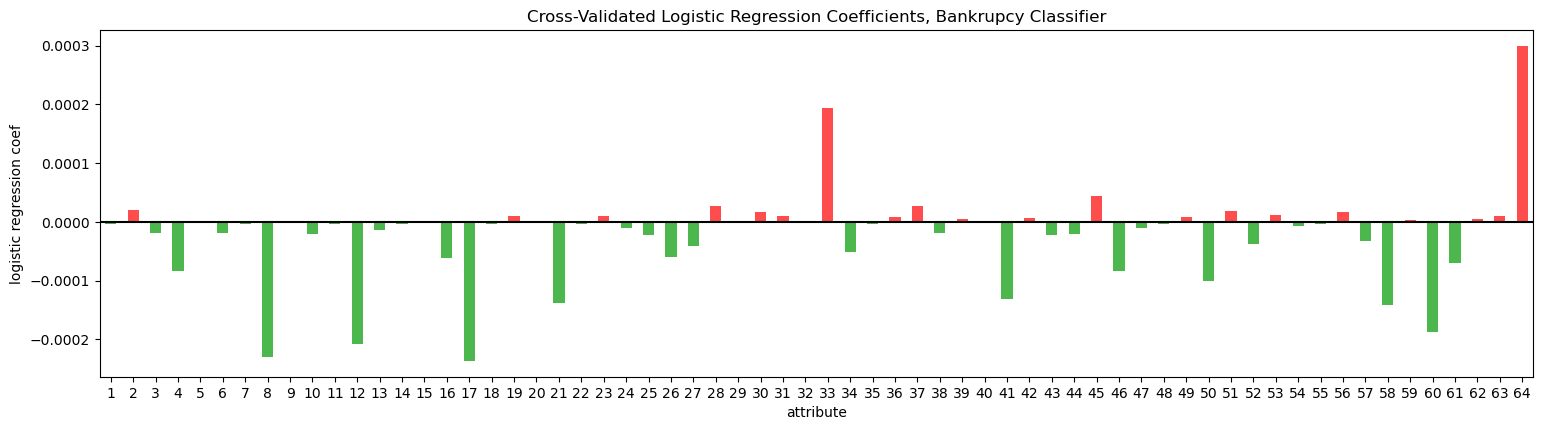

In [50]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = lr_model3.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Cross-Validated Logistic Regression Coefficients, Bankrupcy Classifier");

In [51]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[8])
print(attributes[12])
print(attributes[17])
print(attributes[60])

attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
book value of equity / total liabilities
gross profit / short-term liabilities
total assets / total liabilities
sales / inventory


In [52]:
print("attribues that incease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[33])
print(attributes[64])

attribues that incease predicted probability of bankrupcy (in desc order of coef size):
====
operating expenses / short-term liabilities
sales / fixed assets


Coefficient Significance:

In [53]:
# finding coefficient significance
lr_model3_sigs = logit_pvalue(lr_model3, x_train_imputed)

/var/folders/_k/mx9qq9x94y3bdxqvpj9jc8qh0000gn/T/ipykernel_14978/65202168.py:18: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))


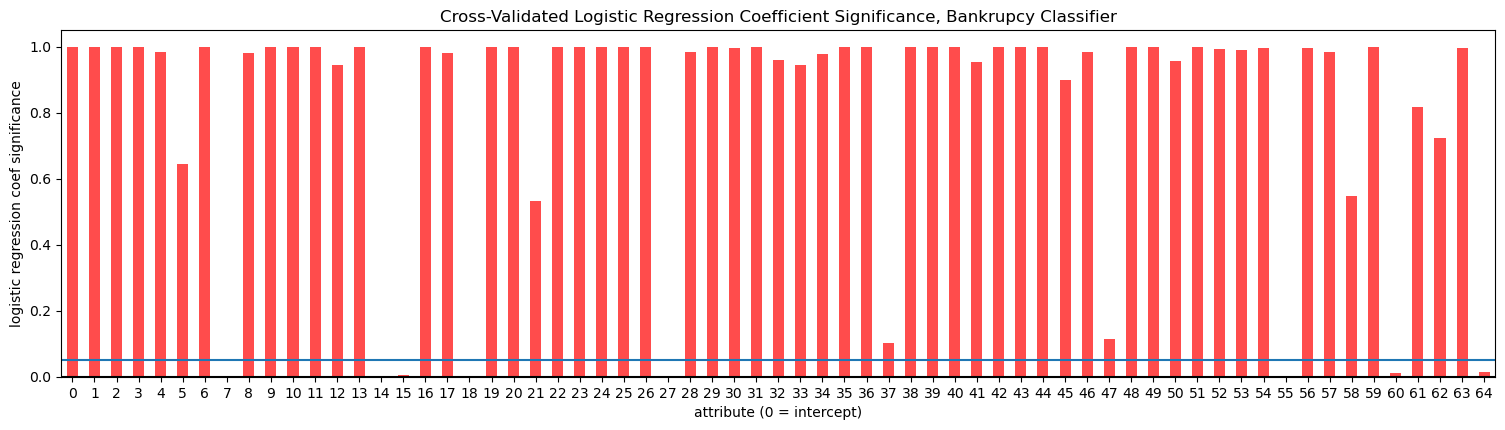

In [54]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(0,65),columns=["attr"])
to_plot["significance"] = lr_model3_sigs

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['significance'] > 0
to_plot['significance'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(0,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute (0 = intercept)");
ax.set_ylabel("logistic regression coef significance");
ax.set_title("Cross-Validated Logistic Regression Coefficient Significance, Bankrupcy Classifier");
ax.axhline(0.05);

In [55]:
print("attibutes with significant (p<=0.05) regression coefficients:")
print("====")
print(attributes[15])
print(attributes[27])
print(attributes[55])
print(attributes[60])
print(attributes[64])

attibutes with significant (p<=0.05) regression coefficients:
====
(total liabilities * 365) / (gross profit + depreciation)
profit on operating activities / financial expenses
working capital
sales / inventory
sales / fixed assets


## Sparsified -> Cross Validated Model *

### Fit

Improving model performance using Regularization

In [118]:
# creating random grid
penalty = ['none','l2','l1','elaticnet']
lam = [x for x in np.linspace(start = 0, stop = 1, num = 100)]

# random grid
random_grid = {'penalty': penalty,'C':lam}

In [119]:
# x imputed with only significant regression coefficients included
x_train_signif = x_train_imputed[["Attr15","Attr27","Attr55","Attr60","Attr64"]]
x_test_signif = x_test_imputed[["Attr15","Attr27","Attr55","Attr60","Attr64"]]

In [120]:
# random grid search
lr_model4 = LogisticRegression();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_model4_rcv = RandomizedSearchCV(estimator = lr_model4, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
lr_model4_rcv.fit(x_train_signif, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielCh

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/DanielCh

In [121]:
# cross-validated hyperparams
pprint(lr_model4_rcv.best_params_)

{'C': 0.7070707070707072, 'penalty': 'none'}


In [122]:
# using cross-validation coefficients
lr_model4 = LogisticRegression(penalty='none',C=0.7070707070707072)
lr_model4.fit(x_train_signif, y_train_imputed)

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.7070707070707072, penalty='none')

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


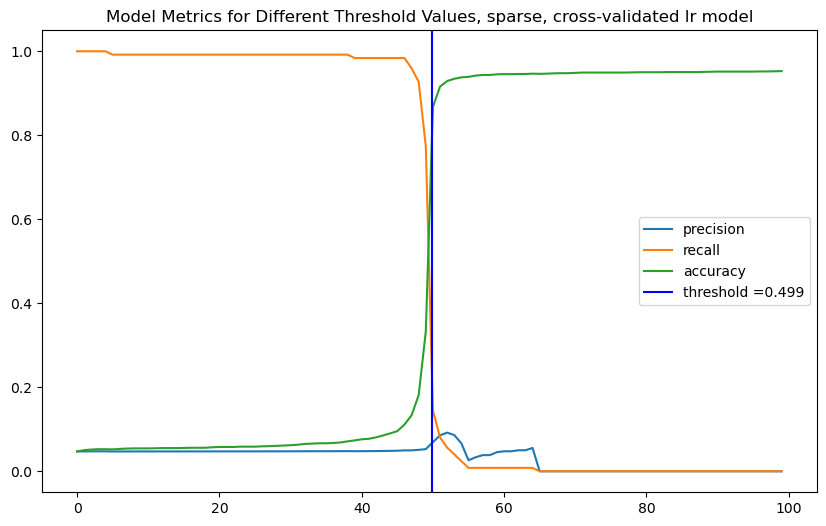

In [172]:
visualize_thresholds("sparse, cross-validated lr model",
                     lr_model4,x_train_signif,y_train_imputed,x_test_signif,y_test_imputed,
                    0.499)

In [206]:
# predictions
lr_model4_preds = lr_model4_rcv.predict(x_test_signif)
# FIXME DELETME?
lr_model4_preds = (lr_model4.predict_proba(x_test_signif)[:,1] >= 0.4982).astype(int)

### Results

New accuracy

In [207]:
accuracy_score(lr_model4_preds, y_test_imputed)

0.5015232292460016

Confusion Matrix

In [208]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model4_preds)
print(cm)

[[1245 1257]
 [  52   72]]


Precision, Recall, F Score

In [209]:
lr_model4_results = precision_recall_fscore_support(y_test_imputed, lr_model4_preds, pos_label=1)
lr_model4_precision, lr_model4_recall, lr_model4_fscore, lr_model4_support = lr_model4_results
print("Precision: " + str(lr_model4_precision[1]))
print("Recall: " + str(lr_model4_recall[1]))
print("F Score: " + str(lr_model4_fscore[1]))

Precision: 0.05417607223476298
Recall: 0.5806451612903226
F Score: 0.09910529938059189


AUC

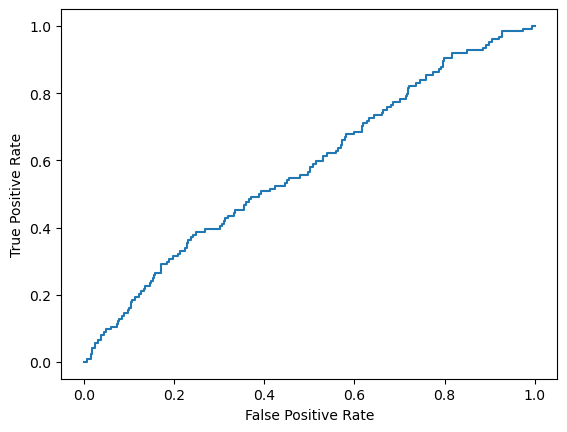

AUC:


0.5785919651375675

In [65]:
y_pred_proba = lr_model2.predict_proba(x_test_signif)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, lr_model4.predict_proba(x_test_signif)[:,1])

PRAUC:

In [66]:
lr_model4_probas = lr_model4.predict_proba(x_test_signif)
average_precision_score(y_test_imputed, lr_model4_probas[:,1],pos_label=1)

0.06323150573388689

### Interpretation

Coefficient Importance

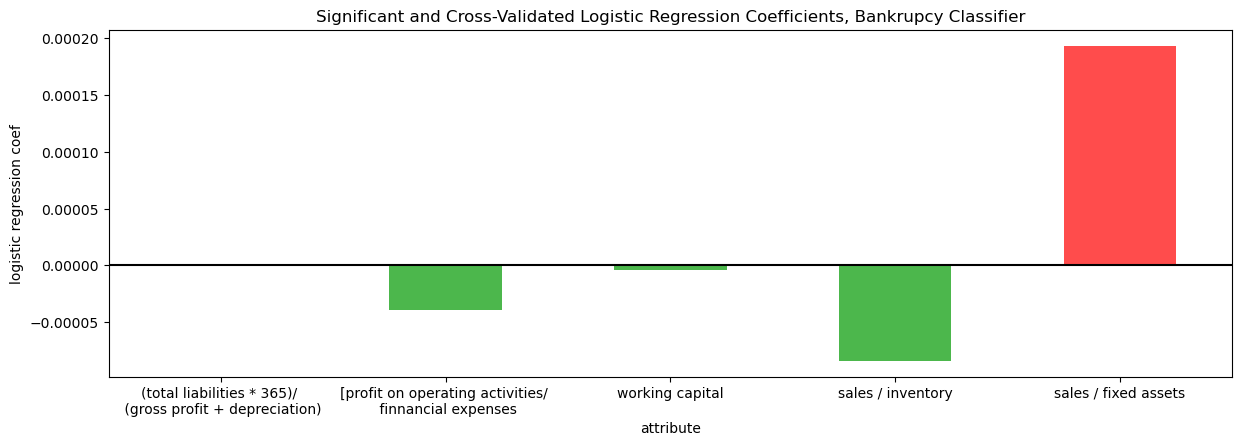

In [224]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame([15,27,55,60,64],columns=["attr"])
to_plot["coef"] = lr_model4.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(14.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(["(total liabilities * 365)/ \n (gross profit + depreciation)",
                    "[profit on operating activities/ \n finnancial expenses",
                    attributes[55],attributes[60],attributes[64]], rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Significant and Cross-Validated Logistic Regression Coefficients, Bankrupcy Classifier");

In [68]:
print("significant attributes that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[60])

significant attributes that decrease predicted probability of bankrupcy (in desc order of coef size):
====
sales / inventory


In [69]:
print("significant attributes that increase predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[64])

significant attributes that increase predicted probability of bankrupcy (in desc order of coef size):
====
sales / fixed assets


# CART

## Initial Model

### Fit

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
cart_model = DecisionTreeClassifier(random_state=42)

In [72]:
cart_model.fit(x_train_imputed,y_train_imputed)

DecisionTreeClassifier(random_state=42)

In [73]:
# predictions
cart_model_preds = cart_model.predict(x_test_imputed)

### Results

Accuracy

In [74]:
cart_model.score(x_test_imputed,y_test_imputed)

0.9295506473724295

Confusion Matrix

In [75]:
cm = metrics.confusion_matrix(y_test_imputed, cart_model_preds)
print(cm)

[[2418   84]
 [ 101   23]]


Precision, Recall, F Score

In [76]:
cart_model_results = precision_recall_fscore_support(y_test_imputed, cart_model_preds, average='macro')
cart_model_precision, cart_model_recall, cart_model_fscore, cart_model_support = cart_model_results
print("Precision: " + str(cart_model_precision))
print("Recall: " + str(cart_model_recall))
print("F Score: " + str(cart_model_fscore))

Precision: 0.5874289975624506
Recall: 0.5759553647404657
F Score: 0.5811444745919949


AUC

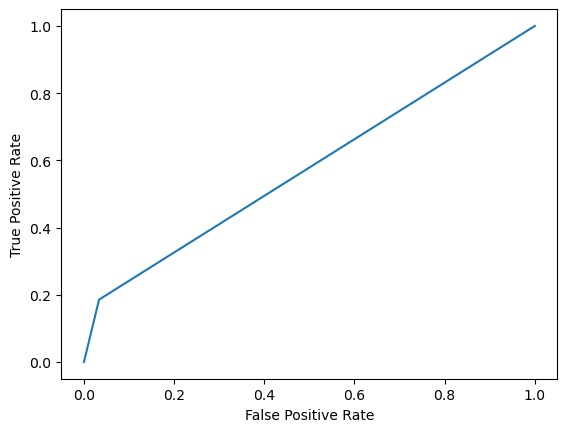

AUC:


0.5759553647404657

In [83]:
y_pred_proba = cart_model.predict_proba(x_test_imputed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, cart_model.predict_proba(x_test_imputed)[:,1])

PRAUC

In [84]:
cart_model_probas = cart_model.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, cart_model_probas[:,1],pos_label=1)

0.078331903248997

### Interpretation

In [85]:
from sklearn.tree import plot_tree

In [86]:
# from user bharys on stack overflow:
def dt_feature_importance(model,normalize=True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx,node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node]+=impurity[idx]*node_samples[idx]- \
                                   impurity[left_c[idx]]*node_samples[left_c[idx]]-\
                                   impurity[right_c[idx]]*node_samples[right_c[idx]]

    # Number of samples at the root node
    feature_importance/=node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance/=normalizer

    return feature_importance

In [87]:
cart_model_importances = dt_feature_importance(cart_model)

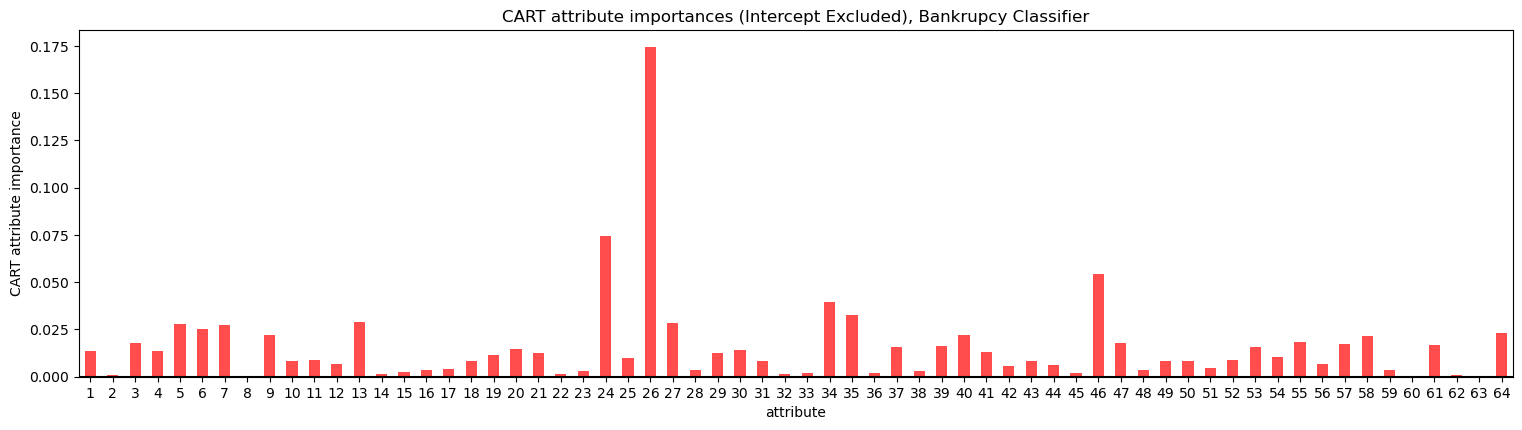

In [88]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = cart_model_importances

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("CART attribute importance");
ax.set_title("CART attribute importances (Intercept Excluded), Bankrupcy Classifier");

In [89]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef importance):")
print("====")
print(attributes[24])
print(attributes[26])

attribues that decrease predicted probability of bankrupcy (in desc order of coef importance):
====
gross profit (in 3 years) / total assets
(net profit + depreciation) / total liabilities


## Cross-Validated Model *

### Fit

In [90]:
# creating random grid
criterion = ["gini", "entropy", "log_loss"]
max_depth = range(1,10)
min_samples_split = range(1,5)
min_samples_leaf = range(1,5)
ccp_alpha = np.linspace(0,1,18)

# random grid
random_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'ccp_alpha': ccp_alpha}

In [91]:
# random grid search
cart_model2 = DecisionTreeClassifier();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cart_model2_rcv = RandomizedSearchCV(estimator = cart_model2, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
cart_model2_rcv.fit(x_train_imputed, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
84 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 265, in fit
    check_scalar(
  File "

In [92]:
# cross-validated hyperparams
pprint(cart_model2_rcv.best_params_)

{'ccp_alpha': 0.0,
 'criterion': 'log_loss',
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 2}


In [93]:
# predictions
cart_model2_preds = cart_model2_rcv.predict(x_test_imputed)

### Results

In [94]:
cart_model2 = DecisionTreeClassifier(ccp_alpha=0.0,
                                     criterion='gini',
                                     max_depth=7,
                                     min_samples_leaf=2,
                                     min_samples_split=2,
                                     random_state=42)
cart_model2.fit(x_train_imputed, y_train_imputed)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, random_state=42)

New Accuracy

In [95]:
cart_model2.score(x_test_imputed, y_test_imputed)

0.7311500380807312

Confusion Matrix

In [96]:
cm = metrics.confusion_matrix(y_test_imputed, cart_model2_preds)
print(cm)

[[1926  576]
 [  53   71]]


Precision, Recall, F Score

In [97]:
cart_model2_results = precision_recall_fscore_support(y_test_imputed, cart_model2_preds, average='macro')
cart_model2_precision, cart_model2_recall, cart_model2_fscore, cart_model2_support = cart_model2_results
print("Precision: " + str(cart_model2_precision))
print("Recall: " + str(cart_model2_recall))
print("F Score: " + str(cart_model2_fscore))

Precision: 0.541478023106607
Recall: 0.6711824089115804
F Score: 0.5219029706346237


AUC

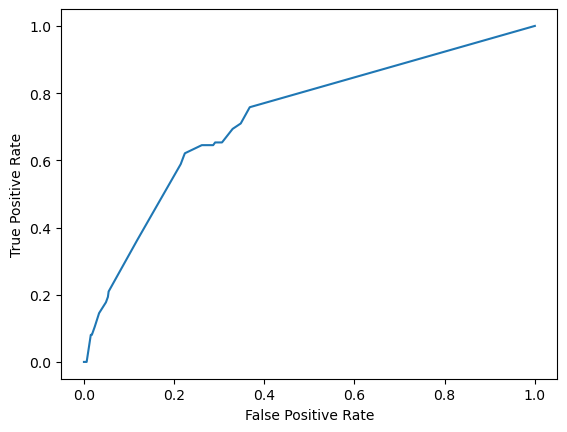

AUC:


0.7273052525721357

In [99]:
y_pred_proba = cart_model2.predict_proba(x_test_imputed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_imputed,  y_pred_proba)

# plotting ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:")
roc_auc_score(y_test_imputed, cart_model2.predict_proba(x_test_imputed)[:,1])

PRAUC

In [100]:
cart_model2_probas = cart_model2.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, cart_model2_probas[:,1],pos_label=1)

0.11397072534390072

[CV] END ..................C=0.08080808080808081, penalty=l2; total time=   0.2s
[CV] END ................C=0.21212121212121213, penalty=none; total time=   0.2s
[CV] END .................C=0.020202020202020204, penalty=l2; total time=   0.2s
[CV] END ................C=0.18181818181818182, penalty=none; total time=   0.2s
[CV] END ....................C=0.696969696969697, penalty=l1; total time=   0.0s
[CV] END ...................C=0.9696969696969697, penalty=l2; total time=   0.2s
[CV] END ................................C=0.0, penalty=none; total time=   0.2s
[CV] END ................................C=0.0, penalty=none; total time=   0.2s
[CV] END ..................C=0.14141414141414144, penalty=l2; total time=   0.2s
[CV] END ..................C=0.14141414141414144, penalty=l2; total time=   0.2s
[CV] END ..................C=0.20202020202020204, penalty=l1; total time=   0.0s
[CV] END ..................C=0.20202020202020204, penalty=l1; total time=   0.0s
[CV] END ..................C

[CV] END .................C=0.7070707070707072, penalty=none; total time=   0.2s
[CV] END ................C=0.21212121212121213, penalty=none; total time=   0.2s
[CV] END .................C=0.020202020202020204, penalty=l2; total time=   0.2s
[CV] END ................C=0.33333333333333337, penalty=none; total time=   0.2s
[CV] END ....................C=0.696969696969697, penalty=l1; total time=   0.0s
[CV] END ............C=0.5757575757575758, penalty=elaticnet; total time=   0.0s
[CV] END ...................C=0.9696969696969697, penalty=l2; total time=   0.2s
[CV] END ............C=0.9797979797979799, penalty=elaticnet; total time=   0.0s
[CV] END ............C=0.6767676767676768, penalty=elaticnet; total time=   0.0s
[CV] END ................................C=1.0, penalty=none; total time=   0.2s
[CV] END ................................C=1.0, penalty=none; total time=   0.2s
[CV] END .................C=0.5858585858585859, penalty=none; total time=   0.2s
[CV] END ................C=0

[CV] END ...................C=0.5252525252525253, penalty=l2; total time=   0.2s
[CV] END ..................C=0.23232323232323235, penalty=l2; total time=   0.2s
[CV] END ..................C=0.23232323232323235, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23232323232323235, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23232323232323235, penalty=l1; total time=   0.0s
[CV] END ...................C=0.6666666666666667, penalty=l1; total time=   0.0s
[CV] END ...................C=0.6666666666666667, penalty=l1; total time=   0.0s
[CV] END ..................C=0.31313131313131315, penalty=l1; total time=   0.0s
[CV] END ...................C=0.9090909090909092, penalty=l2; total time=   0.2s
[CV] END ................C=0.14141414141414144, penalty=none; total time=   0.2s
[CV] END ..................C=0.10101010101010102, penalty=l1; total time=   0.0s
[CV] END ....................C=0.696969696969697, penalty=l1; total time=   0.0s
[CV] END ............C=0.575

[CV] END .................C=0.7070707070707072, penalty=none; total time=   0.2s
[CV] END ...................C=0.8282828282828284, penalty=l2; total time=   0.2s
[CV] END ...................C=0.9090909090909092, penalty=l2; total time=   0.2s
[CV] END ................C=0.18181818181818182, penalty=none; total time=   0.2s
[CV] END .................C=0.9494949494949496, penalty=none; total time=   0.2s
[CV] END ..........C=0.030303030303030304, penalty=elaticnet; total time=   0.0s
[CV] END ............C=0.9797979797979799, penalty=elaticnet; total time=   0.0s
[CV] END ................................C=0.0, penalty=none; total time=   0.2s
[CV] END ................................C=1.0, penalty=none; total time=   0.2s
[CV] END ...................C=0.2828282828282829, penalty=l2; total time=   0.2s
[CV] END ...................C=0.2828282828282829, penalty=l2; total time=   0.2s
[CV] END ...................C=0.2828282828282829, penalty=l2; total time=   0.2s
[CV] END ...................

### Interpretation

Coefficient Importances

In [107]:
cart_model2_importances = dt_feature_importance(cart_model2)

[Text(171.6721875, 203.85, '(net profit + depreciation) / total liabilities <= 0.218\ngini = 0.5\nsamples = 15012\nvalue = [7506, 7506]'),
 Text(91.546875, 176.67000000000002, 'gross profit (in 3 years) / total assets <= 0.054\ngini = 0.465\nsamples = 9944\nvalue = [3661, 6283]'),
 Text(46.7325, 149.49, 'profit on sales / sales <= 0.082\ngini = 0.413\nsamples = 6555\nvalue = [1908, 4647]'),
 Text(26.505, 122.31, '(current assets - inventory) / short-term liabilities <= 0.482\ngini = 0.402\nsamples = 6397\nvalue = [1785, 4612]'),
 Text(8.370000000000001, 95.13, 'rotation receivables + inventory turnover in days <= 27.097\ngini = 0.323\nsamples = 3085\nvalue = [626, 2459]'),
 Text(5.58, 67.94999999999999, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(11.16, 67.94999999999999, '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 <= -61.066\ngini = 0.311\nsamples = 3046\nvalue = [587, 2459]'),
 Text(5.58, 40.770000000000

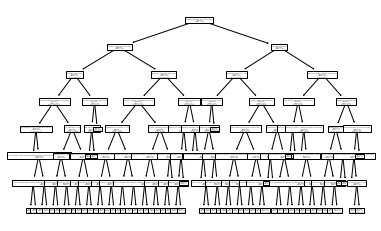

In [108]:
plot_tree(cart_model2, feature_names=list(attributes.values()))

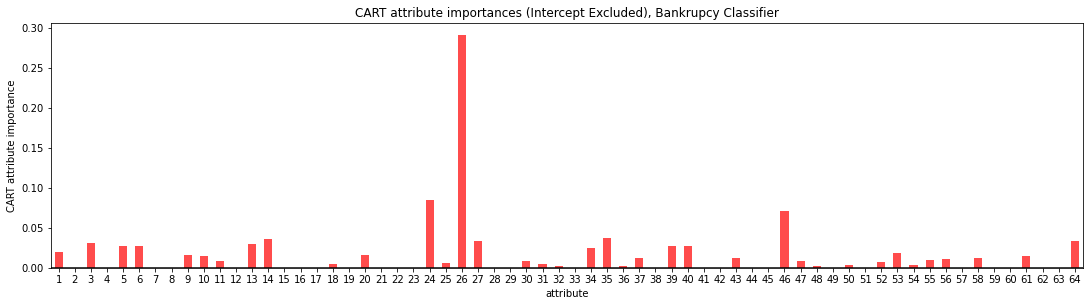

In [109]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = cart_model2_importances

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("CART attribute importance");
ax.set_title("CART attribute importances (Intercept Excluded), Bankrupcy Classifier");

In [116]:
print("significant attributes for bankrupcy:")
print("====")
print(attributes[26])

significant attributes for bankrupcy:
====
(net profit + depreciation) / total liabilities
